## 02 Fourierova transformace

In [1]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
import scipy.misc
import cv2
import math
from numpy import zeros, newaxis
from cmath import exp, pi

In [2]:
def load_image(path):
    im = cv2.imread("./imgs/"+path)
    return im

def save_image(img, path):
    cv2.imwrite("./results/"+path, img)

In [3]:
lena = load_image("lena.jpg")
marlon = load_image("marlon.jpg")
mesic = load_image("mesic.jpg")
hvezda = load_image("hvezda.jpg")
hvezda50 = load_image("hvezda50.jpg")
hvezda64 = load_image("hvezda64.jpg")
line = load_image("line.jpg")

In [4]:
# apmplitude spectrum scale from complex FT output
def log_scale(img):
    sc = img.copy()

    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            pixel = sc[i,j] 
            sc[i,j] = np.log(np.sqrt(pow(pixel.real,2) + pow(pixel.imag,2)))
            
    sc_max = np.max(sc.real)
    sc_min = np.min(sc.real)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #values in interval 0,1 
            sc[i,j] = (sc[i,j]-sc_min)/(sc_max-sc_min) 
            sc[i,j] = int(np.clip(sc[i,j],0.,1.)*255)
    #print(np.max(sc.real), np.min(sc.real))

    return sc

# shift for centered view
# low frequences are in the center instead of the corners
def fft_shift(fft):
    half_h = int(fft.shape[0]/2)
    half_w = int(fft.shape[1]/2)
    
    fft_p = fft.copy()
    #print(half_h, half_w)
    fft_p[:half_h, :half_w,:] = fft[half_h:, half_w:,:] #D
    fft_p[:half_h, half_w:,:] = fft[half_h:, :half_w,:] #B
    
    fft_p[half_h:, :half_w,:] = fft[:half_h, half_w:,:] #C
    fft_p[half_h:, half_w:,:] = fft[:half_h, :half_w,:] #A
    return fft_p

### Discrete Fourier Transform 

In [5]:
def dft(img):
    img =  img/255.0 #normed

    fft = img.copy()
    N, M, c = img.shape
    print("Velikost:",N, M)
    channel = img[:,:,0] + 1j* np.zeros((N,M))

    for u in range(int(N)):
        for v in range(int(M)):
            sum_A = complex(0,0)
            for x in range(int(N)):
                for y in range(int(M)):
                    a = ((u*x)/float(N) + (v*y)/float(M))
                    sum_A += complex(img[x,y,0],0) * exp(-2j * pi * a)
                          
            channel[u,v] = complex(1/N*M,0) * sum_A     

    
    channel = log_scale(channel)
    for chan in range(c):
        fft[:,:,chan] = channel
    
    fft_p = fft_shift(fft)
    
    return fft,fft_p, channel

### Fast Fourier Transform

In [79]:
def fft1(x):
    N = int(len(x))    
    #recursion
    if N == 1:
        #print(x.shape)
        return x
    even = fft1(x[::2])
    odd  = fft1(x[1::2])
    
    result = [0]*N
    
    half = int(N/2)
    for k in range(half):
        result[k] = even[k] + odd[k] * exp((-2*pi*1j*k)/N)
        result[k+half] = even[k] - odd[k] * exp((-2*pi*1j*k)/N)
        
    #print(len(result))
    return result


def fft(img, log_sc):
    img =  img/255.0 #normed
    N, M, c = img.shape

    #print("Velikost:",N, M)
    channel = img[:,:,0]
    n = 2 ** int(math.ceil(math.log(N, 2))) # padding na velikost 2**a
    m = 2 ** int(math.ceil(math.log(M, 2)))
    
    #print("Velikost:",n, m)
    F = np.zeros((n,m))
    fft = np.zeros((n,m,c))
    test = np.zeros((n,m,c))
    F[:N,:M] = channel 
    
    #print(F.shape)
    first_F = np.transpose(fft1(F))
    #print(len(fft1(F)),first_F.shape,"Second:")
    second_F = np.transpose(fft1(first_F))
    #print(second_F.shape)
    second_F = log_scale(second_F)


    if(len(img.shape) > 2):
        for chan in range(c):
            #test[:,:,chan] = F*255
            fft[:,:,chan] = second_F
        
        
    fft_p = fft_shift(fft)
    
    return fft,fft_p, channel

In [80]:
inputs = [marlon, hvezda, mesic, lena, line]
outputs = ["marlon", "hvezda", "mesic", "lena", "line"]
for i,o in zip(inputs[1:2], outputs[1:2]):
    image_fft,image_fftshift, M = fft(i,1.0)
    save_image(image_fftshift, o+"_fft2.png")
    #save_image(M, o+"_test.png")

/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: ComplexWarning: Casting complex values to real discards the imaginary part


In [81]:
%%html
<div>
<img src="./imgs/hvezda.jpg" width="200" /> 
<img src="./results/hvezda_test.png" width="200" />
<img src="./results/hvezda_fft2.png" width="200" />
<img src="./results/hvezda_dft.png" width="200" />
</div>

### Runs:

In [7]:
inputs = [marlon, hvezda, mesic, lena, line]
outputs = ["marlon", "hvezda", "mesic", "lena", "line"]

In [8]:
## DFT tested nly on very small images (100x100 px)
for i,o in zip(inputs[1:2], outputs[1:2]):
    image_fft,image_fftshift, M = dft(i)
    save_image(image_fftshift, o+"_dft.png")

Velikost: 100 100


/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: ComplexWarning: Casting complex values to real discards the imaginary part


In [9]:
%%html
<div>
<img src="./imgs/hvezda.jpg" width="200" /> 
<img src="./results/hvezda_dft.png" width="200" />
</div>

In [10]:
for i,o in zip(inputs[:], outputs[:]):
    image_fft,image_fftshift, M = fft(i,1.0)
    save_image(image_fftshift, o+"_fft.png")

/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()
/home/girlingreyshirt/.local/lib/python3.5/site-packages/ipykernel_launcher.py:37: ComplexWarning: Casting complex values to real discards the imaginary part


In [11]:
%%html
<div>
<img src="./imgs/lena.jpg" width="200" /> 
<img src="./results/lena_fft.png" width="200" />
</div>

In [12]:
%%html
<div>
<img src="./imgs/hvezda.jpg" width="200" /> 
<img src="./results/hvezda_fft.png" width="200" />
</div>

In [13]:
%%html
<div>
<img src="./imgs/mesic.jpg" width="200" /> 
<img src="./results/mesic_fft.png" width="200" />
</div>

In [14]:
%%html
<div>
<img src="./imgs/marlon.jpg" width="200" /> 
<img src="./results/marlon_fft.png" width="200" />
</div>

In [15]:
%%html
<div>
<img src="./imgs/line.jpg" width="200" /> 
<img src="./results/line_fft.png" width="200" />
</div>

#### Testing my output against np.fft results

In [20]:
def a_fft(img, radius = 200):
    print("img shape", img.shape)
    
    a, b = img.shape
    if(a%2 != 0):
        img = img[:-1,:]
    if(b%2 != 0):
        img = img[:,1:]
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    # calculate amplitude spectrum
    mag_spec = 20*np.log(np.abs(fshift))
    print("ft shape", f.shape)
    print("center point ", (f.shape[0]//2,f.shape[1]//2))
    
    r = f.shape[0]//2        # number of rows/2
    c = f.shape[1]//2        # number of columns/2   
    p = 3                         
    n = 1                   # to suppress all except for the DC component       
    fshift2 = np.copy(fshift)
    
    # suppress upper part
    #fshift2[0:r-n , c-p:c+p] = 0.001
    # suppress lower part
    #fshift2[r+n:r+r, c-p:c+p] = 0.001
    # suppress horizontal
    #fshift2[r-n:r+n, :500] = 0.001
    #fshift2[r-n:r+n, -500:] = 0.001
    # suppress vertical
    #fshift2[:250, c-n:c+n] = 0.001
    #fshift2[-250:, c-n:c+n] = 0.001
    
    for x in range(0,2*r):
        for y in range(0,2*c):
            distance_x = np.abs(r-x)
            distance_y = np.abs(c-y)
            hypotenuse = np.sqrt(distance_x**2 + distance_y**2)
            if(hypotenuse > radius):
                fshift2[x,y] = 0.001
            
        

    # calculate new amplitude spectrum
    mag_spec2 = 20*np.log(np.abs(fshift2))
    inv_fshift = np.fft.ifftshift(fshift2)
    # reconstruct image
    img_recon = np.real(np.fft.ifft2(inv_fshift))
    

    plt.figure(figsize=(15,10))
    plt.subplot(131),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(mag_spec, cmap = 'gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(mag_spec2, cmap = 'gray')
    plt.title('Magnitude Spectrum after suppression'), plt.xticks([]), plt.yticks([])
    plt.show()

    plt.figure(figsize=(15,10))
    plt.subplot(121),plt.imshow(img, cmap = 'gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img_recon, cmap = 'gray')
    plt.title('Output Image'), plt.xticks([]), plt.yticks([])
    plt.show()

    return img_recon
    

img shape (128, 128)
ft shape (128, 128)
center point  (64, 64)


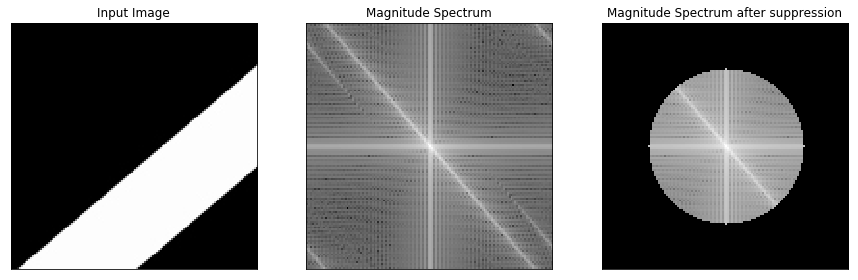

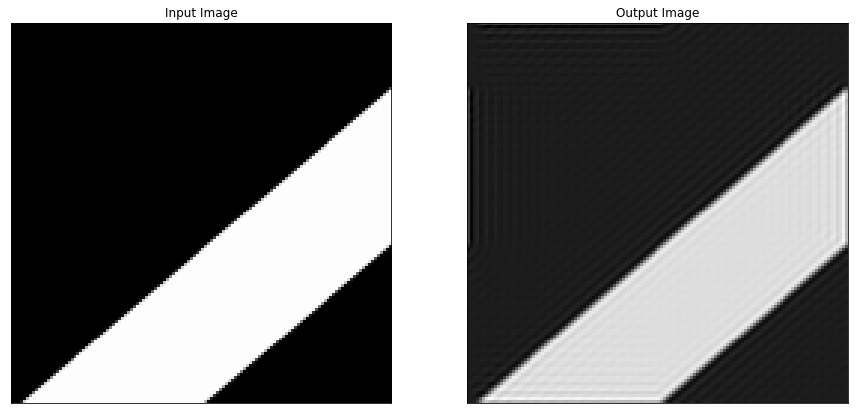

In [21]:
im = a_fft(line[:,:,0], 40)